# Class SR fit across multiple model at same age

In [27]:
# External packages
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering
import torch
import pandas as pd
import random

# Internal code import
import physo
import physo.learn.monitoring as monitoring
from physo.benchmark.utils import symbolic_utils as su
import sympy
from sympy import lambdify
import copy

In [2]:
DATA_PATH = '../Nbody/'

In [3]:
def list_folders(path):
    # List all entries in the directory given by path
    entries = os.listdir(path)
    # Filter out only directories
    folders = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
    return [s for s in folders if '_' in s]

In [4]:
def load_data(model_name, myvars, simrange='mass_0.0-0.5', simtype='mass'):
    data = {}
    for name, filetag in myvars.items():
        data[name] = pd.read_csv(DATA_PATH + model_name + "/{}/{}_{}.dat".format(simtype,simrange,filetag), \
                                 delimiter=" ", header=None).to_numpy()
    data['age'] = pd.read_csv(DATA_PATH + model_name + "/age.dat", sep=r"\s+", header=None).to_numpy().flatten()
    
    return data

In [5]:
def select_slice(data, ref_age):
    idx = np.argmin(np.abs(data['age']-ref_age))
    myslice = copy.copy(data)
    for name in set(data.keys()) - set(['age']):
        myslice[name] = data[name][idx,:]
    myslice['age'] = ref_age
    return myslice

In [6]:
def dropna(data):
    selected_idx = ~np.isnan(data['mass'])
    for name in set(data.keys()) - set(['age']):
        data[name] = data[name][selected_idx]
    return data

In [7]:
def reduce(data, ref_var='mass', factor=100):
    selected_idx = range(0, len(data[ref_var]), factor)
    reduced = copy.copy(data)
    reduced['age'] = np.concatenate([np.full_like(data[ref_var][idx], data['age'][idx]) for idx in selected_idx])
    for name in set(data.keys()) - set(['age']):
        reduced[name] = data[name][selected_idx]
    return reduced

In [8]:
def target_vars(variables, ref_vars=['mass', 'age']):
    return list(set(variables)-set(ref_vars))

In [9]:
models = list_folders(DATA_PATH)
print(models)

['250k_A_R2_10', '250k_A_R4_25_imf50', '250k_A_R4_25_retr', '250k_A_R4_25_lk', '250k_A_R2_25_vlk', '500k_C_R4_10', '250k_C_R2_10', '250k_C_R4_25', '250k_A_R4_25', '500k_A_R4_LC_part2', '250k_B_R4_25', '250k_C_R4_25_lk', '1.5M_A_R4_10', '250k_B_R4_25_lk', '250k_A_R2_25', '250k_C_R4_10', '250k_A_R2_5', '250k_A_R4_10', '250k_W6_R4_25_retr', '250k_W6_R4_25', '500k_A_R2_10', '250k_A_R4_10_retr', '250k_A_R4_25_vlk', '500k_A_R4_10', '500k_A_R4_LC_part1']


In [10]:
variables = {'mass': 'mass_bin', 'velocity': 'vphi', 'dispersion': 'disp_phi', 'radius': 'radial_bin'}
labels = {'mass': r"$mass$ [M\_\odot]", 'velocity': r"$v_\phi$ [km/s]", 'dispersion': r"$\sigma_\phi$ [km/s]", 'radius': 'r [km]'}

## Take a slice at given age across multiple models

In [12]:
ref_age = 10000 # Myr

data = {}
for model in models:
    full_dataset = load_data(model, variables)
    data[model] = dropna(select_slice(full_dataset, ref_age))

## Store in multi X and y arrays

Text(0, 0.5, '$\\sigma_\\phi$ [km/s]')

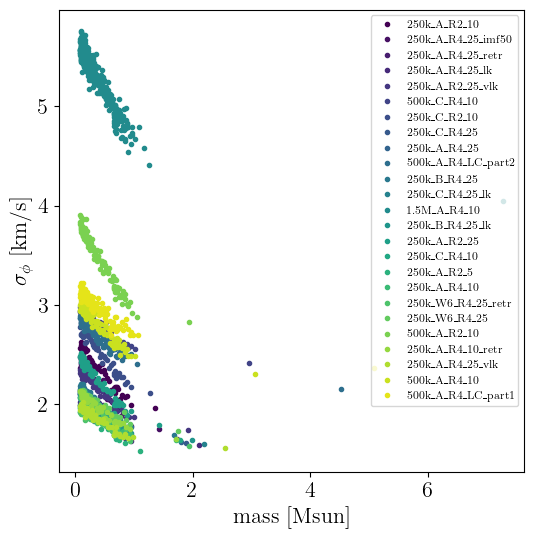

In [51]:
multiX = [np.reshape(d['mass'], (1, -1)) for d in data.values()]
multiy = [d['dispersion'] for d in data.values()]
# print(len(multiX), len(multiX[0]))

fig, ax = plt.subplots(1, figsize=(6,6))
cmap = plt.get_cmap('viridis')
for n, (m, d, label) in enumerate(zip(multiX,multiy,data.keys())):
    color = cmap(n / len(multiX))
    ax.plot(m.flatten(), d.flatten(), '.', color=color,label=label)
ax.legend(fontsize=8)
ax.set_xlabel("mass [Msun]")
ax.set_ylabel(labels['dispersion'])

### Logging config

In [41]:
save_path_training_curves = 'demo_curves.png'
save_path_log             = 'demo.log'

run_logger     = lambda : monitoring.RunLogger(save_path = save_path_log,
                                                do_save = True)

run_visualiser = lambda : monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

In [ ]:
expression, logs = physo.ClassSR(multiX, multiy,
                            # Giving names of variables (for display purposes)
                            X_names = ["m"],
                            # Associated physical units (ignore or pass zeroes if irrelevant)
                            X_units = [ [0, 0, 1] ],
                            # Giving name of root variable (for display purposes)
                            y_name  = ["s"],
                            y_units = [1, -1, 0],
                            # Fixed constants
                            # fixed_consts=[6.67430*1e-11,3e8],
                            # fixed_consts_units=[[3,-2,-1],[1,-1,0]], 
                            # Whole class free constants
                            class_free_consts_names = [ "v0", "m0"],
                            class_free_consts_units = [[1, -1, 0] , [0, 0, 1]],
                            # Realization specific free constants
                            # spe_free_consts_names = ["k0", "k1"],
                            # spe_free_consts_units = [[0, 0, 0] , [0, 0, 0]],
                            # Run config
                            run_config = physo.config.config0b.config1b,
                            # Symbolic operations that can be used to make f
                            op_names = ['mul', 'add', 'sub','div', 'inv', 'n2', 'sqrt', 'neg', 'exp', 'log'],
                            get_run_logger     = run_logger,
                            get_run_visualiser = run_visualiser,
                            # Parallel mode (only available when running from python scripts, not notebooks)
                            parallel_mode = False,
                            # Number of iterations
                            epochs = 20)

/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/task/args_handler.py:117: UserWarning: No information about fixed constants, not using any.
  warnings.warn("No information about fixed constants, not using any.")
/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/task/args_handler.py:126: UserWarning: No units given for fixed constants, assuming dimensionless units.
  warnings.warn("No units given for fixed constants, assuming dimensionless units.")
/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/task/args_handler.py:175: UserWarning: No information about spe free constants, not using any.
  warnings.warn("No information about spe free constants, not using any.")
/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run ph

Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
SR task started...
=========== Epoch 00000 ===========
-> Time 4.32 s
-> Memory Usage: 1718.02 MB

Overall best  at R=0.502687
-> Raw expression : 
                                 2
        ⎛                    0.5⎞ 
        ⎜     ⎛   ⎛ 2     2⎞⎞   ⎟ 
        ⎜     ⎜m₀⋅⎝m  - m₀ ⎠⎟   ⎟ 
     v₀⋅⎜-m + ⎜─────────────⎟   ⎟ 
        ⎝     ⎝     m₀      ⎠   ⎠ 
v₀ + ─────────────────────────────
                 m₀⋅m₀            

Best of epoch at R=0.502687
-> Raw expression : 
                                 2
        ⎛                    0.5⎞ 
        ⎜     ⎛   ⎛ 2     2⎞⎞   ⎟ 
        ⎜     ⎜m₀⋅⎝m  - m₀ ⎠⎟   ⎟ 
     v₀⋅⎜-m + ⎜─────────────⎟   ⎟ 
        ⎝     ⎝     m₀      ⎠   ⎠ 
v₀ + ─────────────────────────────
                 m₀⋅m₀            




/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00001 ===========
-> Time 9.59 s
-> Memory Usage: 1726.54 MB

Overall best  at R=0.502687
-> Raw expression : 
                                 2
        ⎛                    0.5⎞ 
        ⎜     ⎛   ⎛ 2     2⎞⎞   ⎟ 
        ⎜     ⎜m₀⋅⎝m  - m₀ ⎠⎟   ⎟ 
     v₀⋅⎜-m + ⎜─────────────⎟   ⎟ 
        ⎝     ⎝     m₀      ⎠   ⎠ 
v₀ + ─────────────────────────────
                 m₀⋅m₀            

Best of epoch at R=0.502290
-> Raw expression : 
                                       2
⎛                                    2⎞ 
⎜           ⎛                      2⎞ ⎟ 
⎜     0.5   ⎜⎛         1          ⎞ ⎟ ⎟ 
⎜- -v₀    + ⎜⎜────────────────────⎟ ⎟ ⎟ 
⎜           ⎜⎜                 0.5⎟ ⎟ ⎟ 
⎜           ⎜⎜⎛      -1       ⎞   ⎟ ⎟ ⎟ 
⎜           ⎜⎜⎜───────────────⎟   ⎟ ⎟ ⎟ 
⎜           ⎜⎜⎜⎛     m₀      ⎞⎟   ⎟ ⎟ ⎟ 
⎜           ⎜⎜⎜⎜─────────────⎟⎟   ⎟ ⎟ ⎟ 
⎜           ⎜⎜⎜⎜          0.5⎟⎟   ⎟ ⎟ ⎟ 
⎜           ⎜⎜⎜⎜⎛    -m  ⎞   ⎟⎟   ⎟ ⎟ ⎟ 
⎜           ⎜⎜⎜⎜⎜m₀⋅─────⎟   ⎟⎟   ⎟ ⎟ ⎟ 
⎜       

/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))
